In [134]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")
import levenberg_marquardt
from matplotlib.pyplot import figure
import heston
from importlib import reload
reload(heston)
from heston import calibrate_heston, get_tick
import datetime
from scipy import stats as sps
from typing import Union
import h5py
import matplotlib.dates as mdates
from tqdm.notebook import tqdm

In [3]:
%%time
raw = pd.HDFStore('../datasets/eth-20230127.h5','r').get("/eth")

CPU times: user 16.2 s, sys: 3.23 s, total: 19.4 s
Wall time: 23.1 s


In [58]:
def process_data(data):
    # only options
    df = data.copy()
    df = df[(df["instrument"].str.endswith("C")) | (df["instrument"].str.endswith("P"))].sort_values("dt")
    df["type"] = np.where(df["instrument"].str.endswith("C"), "call", "put")
    
    perpetuals = data[data["instrument"].str.endswith("PERPETUAL")][["dt", "price"]].copy()
    perpetuals = perpetuals.rename(columns = {"price": "underlying_price"}).sort_values("dt")
    
    def get_strike(x):
        return int(x.split("-")[2])
    
    def get_expiration(x):
        return x.split("-")[1]
    

    df["strike_price"] = df["instrument"].apply(get_strike)
    df["expiration"] = df["instrument"].apply(get_expiration)
    
    def unix_time_millis(dt):
        epoch = datetime.datetime.utcfromtimestamp(0)
        return int((dt - epoch).total_seconds() * 1000_000)
    
    def get_normal_date(s):
        """Function to convert date to find years to maturity"""
        monthToNum = {
            "JAN": 1,
            "FEB": 2,
            "MAR": 3,
            "APR": 4,
            "MAY": 5,
            "JUN": 6,
            "JUL": 7,
            "AUG": 8,
            "SEP": 9,
            "OCT": 10,
            "NOV": 11,
            "DEC": 12,
        }

        full_date = s.split("-")[1]
        try:
            day = int(full_date[:2])
            month = monthToNum[full_date[2:5]]
        except:
            day = int(full_date[:1])
            month = monthToNum[full_date[1:4]]
        
        year = int("20" + full_date[-2:])
        exp_date = datetime.datetime(year, month, day)
        return unix_time_millis(exp_date)
    
    df["dt"] = pd.to_datetime(df["dt"])
    perpetuals["dt"] = pd.to_datetime(perpetuals["dt"])
    
    df = pd.merge_asof(df, perpetuals, on="dt",
                       tolerance=pd.Timedelta('7 minutes'),
                       direction='nearest',)
    
    df["timestamp"] = df["dt"].apply(unix_time_millis)
    df["expiration"] = df["instrument"].apply(get_normal_date)
    df = df.rename(columns = {"price": "mark_price"})
    
    
    return df


In [5]:
%%time
start = process_data(raw)


CPU times: user 38.1 s, sys: 18.2 s, total: 56.4 s
Wall time: 1min 18s


In [6]:
df = start.copy()

In [241]:
df = pd.read_csv(f"../datasets/deribit_options_chain_2022-12-01_OPTIONS.csv")
df = df.drop(columns = ["exchange", "open_interest", 
                    "last_price", "bid_price", "bid_amount", "bid_iv",
                           "ask_price", "ask_amount", "ask_iv", "underlying_index",
                           "delta", "gamma", "vega", "theta" ,"rho"])
currency = "ETH"
ind = [symbol.startswith(currency) for symbol in df.symbol]
df = df[ind].reset_index(drop=True)

# after expiration
df = df[df["timestamp"] > 1669881600000000]
# df = df[df["timestamp"]<=1669928620213347.0]

In [242]:
df

,symbol,timestamp,local_timestamp,type,strike_price,expiration,mark_price,mark_iv,underlying_price
3476793,ETH-2DEC22-1275-C,1669881600006000,1669881600016350,call,1275,1669968000000000,0.0148,63.61,1278.7800
3476794,ETH-2DEC22-1275-P,1669881600008000,1669881600018281,put,1275,1669968000000000,0.0118,63.61,1278.8500
3476795,ETH-9DEC22-1300-C,1669881600019000,1669881600021957,call,1300,1670572800000000,0.0327,67.95,1278.8200
3476796,ETH-2DEC22-1275-P,1669881600016000,1669881600024663,put,1275,1669968000000000,0.0118,63.61,1278.8500
3476797,ETH-9DEC22-1250-P,1669881600017000,1669881600024684,put,1250,1670572800000000,0.0305,69.92,1278.8200
...,...,...,...,...,...,...,...,...,...
11322868,ETH-24FEB23-1400-P,1669939199495000,1669939199513372,put,1400,1677225600000000,0.2027,73.90,1273.6311
11322869,ETH-27JAN23-1100-P,1669939199500000,1669939199513437,put,1100,1674806400000000,0.0625,81.75,1274.4400
11322870,ETH-16DEC22-1400-P,1669939199497000,1669939199513443,put,1400,1671177600000000,0.1199,70.90,1275.5933
11322871,ETH-23DEC22-1300-P,1669939199499000,1669939199513449,put,1300,1671782400000000,0.0809,72.87,1275.3967


In [135]:
# df.sample(1)

In [130]:
# calibrate_heston(df, start_params, 1673213743181000, "all")

In [129]:
# calibrate_heston(df, start_params, 1673213743181000, "nu0")

In [243]:
# calibrate base
number_of_dots = 50
timestamps_hm = []
names = ["kappa", "nu_bar", "sigma", "rho", "nu0"]
kappas_all, nu_bars_all, sigmas_all, rhos_all, nu0s_all, errors_all = [], [], [], [], [], []
kappas_nu0, nu_bars_nu0, sigmas_nu0, rhos_nu0, nu0s_nu0, errors_nu0 = [], [], [], [], [], []

a = np.float64(3.0)  # kappa                     |  mean reversion rate | kappa (Article) | kappa (Roland's)
b = np.float64(0.1)  # v_infinity                |  long term variance | nu_bar           | alpha_bar 
c = np.float64(0.25)  # sigma                    |  volatility of volatility | sigma      | mu
rho = np.float64(0.01)  # rho                    |  correlation between spot and vol |rho | rho
v0 = np.float64(0.08) # init variance            | initial variance | nu_0                | alpha_0
start_params = np.array([a, b, c, rho, v0])
print("Optimize first params with random start once")
calibrated_params_all, first_error_all = calibrate_heston(df = df, start_params = start_params, calibration_type = "all")
calibrated_params_nu0, first_error_nu0 = calibrate_heston(df = df, start_params = start_params, calibration_type = "nu0")
print("all first calibrated", calibrated_params_all)
print("all nu0 calibrated", calibrated_params_nu0)

# Get ticks with similar distnce from available data
timestamps = np.linspace(df.timestamp.min(), df.timestamp.max(), number_of_dots)
for timestamp in tqdm(timestamps):
    try:
        # zero params for each point are params from last step
        calibrated_params_all, error_all = calibrate_heston(df = df, start_params = calibrated_params_all, 
                                                            timestamp = timestamp, calibration_type = "all")
        calibrated_params_nu0, error_nu0 = calibrate_heston(df = df, start_params = calibrated_params_nu0, 
                                                            timestamp = timestamp, calibration_type = "nu0")

        # save all calib_params
        kappas_all.append(calibrated_params_all[0])
        nu_bars_all.append(calibrated_params_all[1])
        sigmas_all.append(calibrated_params_all[2])
        rhos_all.append(calibrated_params_all[3])
        nu0s_all.append(calibrated_params_all[4])
        errors_all.append(error_all)

        # save nu0 calib params
        kappas_nu0.append(calibrated_params_nu0[0])
        nu_bars_nu0.append(calibrated_params_nu0[1])
        sigmas_nu0.append(calibrated_params_nu0[2])
        rhos_nu0.append(calibrated_params_nu0[3])
        nu0s_nu0.append(calibrated_params_nu0[4])
        errors_nu0.append(error_nu0)
        
        timestamps_hm.append(timestamp)
        
    except ValueError:
        # if could not calibrate, start next calibration with random params
#         calibrated_params = start_params
        print(f"Could not calibrate LM on {timestamp}")
        calibrated_params_all = start_params
        calibrated_params_nu0 = start_params
        
    except IndexError:
        print(f"Could not calibrate nu0 {timestamp}")
        calibrated_params_all = start_params
        calibrated_params_nu0 = start_params
        
    except ZeroDivisionError:
        print(f"Could not find jacobian on {timestamp}")
        calibrated_params_all = start_params
        calibrated_params_nu0 = start_params
        
    


Optimize first params with random start once
all first calibrated [ 0.17092677  7.25311292  3.23021918 -0.3972674   0.64442593]
all nu0 calibrated [ 5.0696327   1.006626    4.97977672 -0.37395538  0.44343238]


  0%|          | 0/50 [00:00<?, ?it/s]

Could not calibrate nu0 1669881600006000.0
Could not find jacobian on 1669882775511183.8
Could not calibrate LM on 1669923918192612.2
Could not calibrate LM on 1669926269202979.5
Could not calibrate LM on 1669929795718530.5
Could not calibrate LM on 1669932146728898.0
Could not calibrate LM on 1669936848749632.8


In [449]:
# single_instr = df[df["instrument"] == df.sample(1).instrument.iloc[0]]
# plt.plot(single_instr["dt"], single_instr["mark_price"])
# plt.plot(df["dt"], df["underlying_price"])

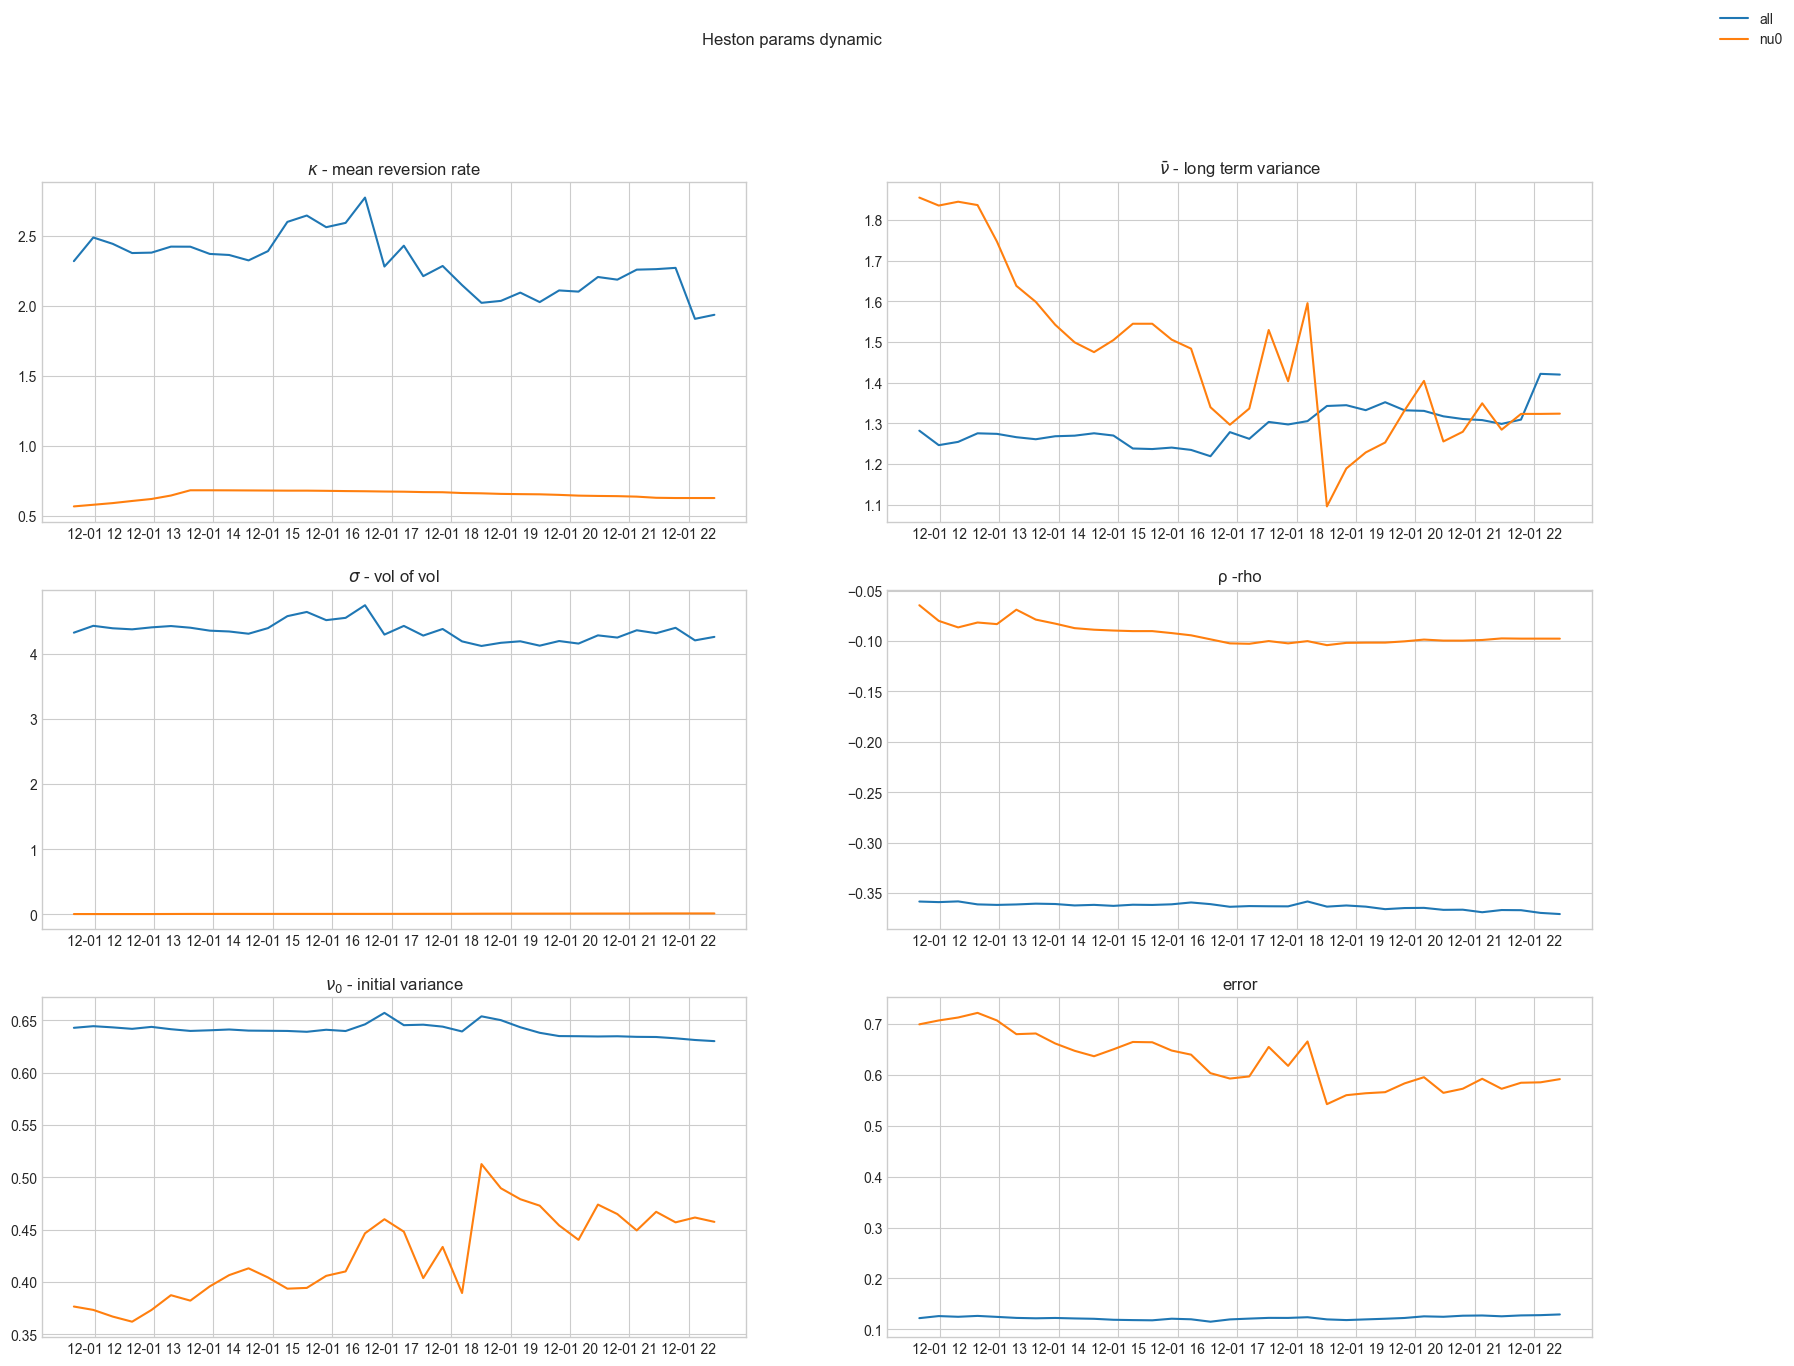

In [251]:
timestamps_hm = [datetime.datetime.fromtimestamp(x/1000000.0) for x in timestamps_hm]
# expirarions = df.expiration.unique()
# expirarions = [datetime.datetime.fromtimestamp(ms/1000000000.0) for ms in expirarions]
# expirarions
fig, axs =  plt.subplots(nrows=3, ncols=2, figsize=(20, 15))

axs[0, 0].plot(timestamps_hm[:-9], kappas_all[:-9])
axs[0, 0].plot(timestamps_hm[:-9], kappas_nu0[:-9])
axs[0, 0].set_title(r"$\kappa$ - mean reversion rate")

axs[0, 1].plot(timestamps_hm[:-9], nu_bars_all[:-9])
axs[0, 1].plot(timestamps_hm[:-9], nu_bars_nu0[:-9])
axs[0, 1].set_title(r"$\bar{\nu}$ - long term variance")

axs[1, 0].plot(timestamps_hm[:-9], sigmas_all[:-9], label = "all")
axs[1, 0].plot(timestamps_hm[:-9], sigmas_nu0[:-9], label = "nu0")
axs[1, 0].set_title(r"$\sigma$ - vol of vol")

axs[1, 1].plot(timestamps_hm[:-9], rhos_all[:-9])
axs[1, 1].plot(timestamps_hm[:-9], rhos_nu0[:-9])
axs[1, 1].set_title("ρ -rho")

axs[2, 0].plot(timestamps_hm[:-9], nu0s_all[:-9])
axs[2, 0].plot(timestamps_hm[:-9], nu0s_nu0[:-9])
axs[2, 0].set_title(r"$\nu_0$ - initial variance")

axs[2, 1].plot(timestamps_hm[:-9], errors_all[:-9])
axs[2, 1].plot(timestamps_hm[:-9], errors_nu0[:-9])
axs[2, 1].set_title("error")



for i in range(3):
    for j in range(2):
        for exp in expirarions:
#             axs[i, j].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
#             axs[i, j].axvline(x=exp, color = "black", linestyle  = "--")
            if i == j == 0:
#                 axs[i, j].axvline(x=exp, color = "black", linestyle  = "--", label = exp)
                pass


plt.figlegend() 
fig.suptitle("Heston params dynamic")

plt.show()